In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')

In [2]:
df=pd.read_csv("complaints.csv/complaints.csv")
df.shape

(4512957, 18)

##EDA AND FEATURE ENGG

In [3]:
df.head(2).T

,0,1
Date received,2023-12-07,2023-12-07
Product,Credit reporting or other personal consumer re...,Credit reporting or other personal consumer re...
Sub-product,Credit reporting,Credit reporting
Issue,Problem with a company's investigation into an...,Incorrect information on your report
Sub-issue,Investigation took more than 30 days,Account status incorrect
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,"TRANSUNION INTERMEDIATE HOLDINGS, INC.","TRANSUNION INTERMEDIATE HOLDINGS, INC."
State,IL,IL
ZIP code,60615,604XX


all the above colums or features are not necessary for text classification only PRODUCT AND CONSUMER COMPLAINT NARATIVE are needed

In [4]:
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Removing null values
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for simplicity
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape

(1636466, 2)

##percentage of complaints with text

In [5]:
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.3

##for more than 4 million complaints there are about 1,452,000 complaints that are not Null which is a good number to work with      now lets look for the unique products in the product features

In [6]:
pd.DataFrame(df.Product.unique()).values

array([['Credit reporting or other personal consumer reports'],
       ['Debt collection'],
       ['Mortgage'],
       ['Money transfer, virtual currency, or money service'],
       ['Vehicle loan or lease'],
       ['Credit card'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Checking or savings account'],
       ['Debt or credit management'],
       ['Student loan'],
       ['Credit card or prepaid card'],
       ['Prepaid card'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Payday loan, title loan, or personal loan'],
       ['Bank account or service'],
       ['Credit reporting'],
       ['Consumer Loan'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

## There are 21 different classes or categories (target). however it is observed that some classes are contained in others For instance ‘Credit card’ and ‘Prepaid card’ are contained in ‘Credit card or prepaid card’ category. being so is not  bad thing as algo can classify it but it still affects the performance of the model so we will make a rename for it.

In [7]:
#Because the computation is time taking (in terms of CPU) the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [8]:
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfers': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [9]:
df2.head()

,Product,Consumer_complaint
1176168,"Credit reporting, repair, or other",Collection agency ( Plus Four ) unable to prov...
3479329,Credit card or prepaid card,Credit card companies will permit people to op...
47,Credit card or prepaid card,I have a Destiny Mastercard. My payment date i...
2524693,"Credit reporting, repair, or other",In accordance with the Fair Credit Reporting a...
579066,Credit card or prepaid card,I tried multiple times to figure out why this ...


In [10]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Credit card or prepaid card
2,Checking or savings account
3,Vehicle loan or lease
4,Credit reporting or other personal consumer re...
5,"Money transfer, virtual currency, or money ser..."
6,Mortgage
7,Debt collection
8,Bank account or service
9,"Payday loan, title loan, or personal loan"


## number of classes were reduced from 21 to 15

In [11]:
# Creating a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

df2.head()

,Product,Consumer_complaint,category_id
1176168,"Credit reporting, repair, or other",Collection agency ( Plus Four ) unable to prov...,0
3479329,Credit card or prepaid card,Credit card companies will permit people to op...,1
47,Credit card or prepaid card,I have a Destiny Mastercard. My payment date i...,1
2524693,"Credit reporting, repair, or other",In accordance with the Fair Credit Reporting a...,0
579066,Credit card or prepaid card,I tried multiple times to figure out why this ...,1


Text(0.5, 0, 'Number of ocurrences')

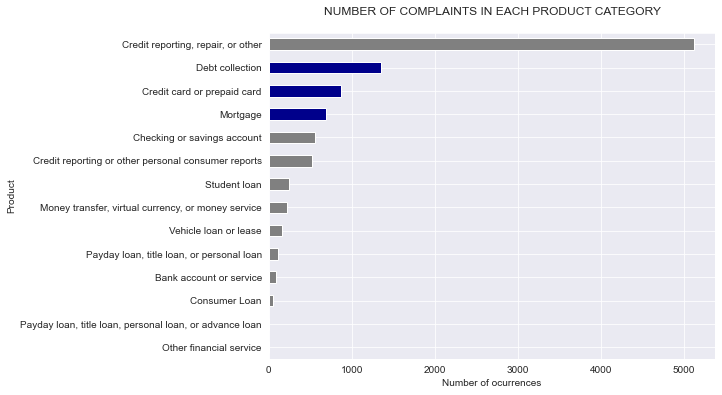

In [12]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10)

## here the most of the complaints are due to ---credit reporting, ---credit repair ---debt collection ---mortgage

## text preprocessing    using TFIDF for knowing how important a word is to a document and by removing stopwords

In [13]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26272 features (TF-IDF score of unigrams and bigrams)


In [14]:
# Finding the four most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  *** Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  *** Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  *** Most Correlated Unigrams are: deposit, bank, overdraft
  *** Most Correlated Bigrams are: overdraft fees, business bank, bank charges

==> Checking or savings account:
  *** Most Correlated Unigrams are: deposit, bank, funds
  *** Most Correlated Bigrams are: access funds, savings account, checking account

==> Consumer Loan:
  *** Most Correlated Unigrams are: chrysler, fin, overcharged
  *** Most Correlated Bigrams are: settle xxxx, chrysler capital, ally financial

==> Credit card or prepaid card:
  *** Most Correlated Unigrams are: rewards, citi, card
  *** Most Correlated Bigrams are: balance transfer, american express, credit card

==> Credit reporting or other personal consumer reports:
  *** Most Correlated Unigrams are: convictions, sections, earnestly
  *** Most Correlated Bigrams are: sections 609, action regarding, 1681 15

==> Credit reporting, repair, or other:
  *** Most Correlated Unigrams are: bank, section, reporting
  *** Most Corr

## classification models to be potentially evauated for multiclass classification ::: 
##     -- Random Forest,Linear Support Vector Machine,Multinomial Naive Bayes,Logistic Regression.

In [15]:
## splitting into train and test set in the ratio of 80-20
X = df2['Consumer_complaint']
y = df2['Product']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

## list of models

In [16]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# performing 5 fold Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

## calculating the average accuracy accross all the folds and selecting the one with high mean accuracy

In [17]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7864,0.004068
LogisticRegression,0.7719,0.006219
MultinomialNB,0.6441,0.004464
RandomForestClassifier,0.5125,0.000354


## the LinearSVC performs better by a margin

Text(0.5, 1.0, 'MEAN ACCURACY (cv = 5)\n')

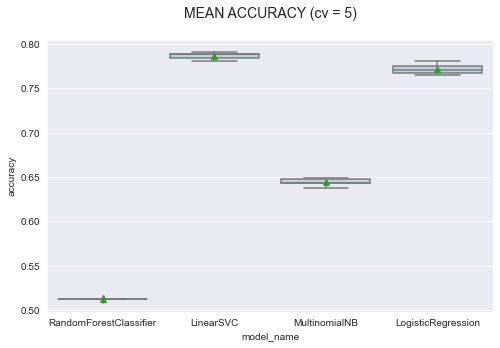

In [18]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14)

## model evaluation(for the best model i.e, LinearSVC)

In [19]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,labels=labels, 
                                    target_names= df2['Product'].unique()))

				CLASSIFICATIION METRICS

                                                         precision    recall  f1-score   support

                     Credit reporting, repair, or other       0.82      0.92      0.87      1287
                            Credit card or prepaid card       0.70      0.74      0.72       208
                            Checking or savings account       0.70      0.74      0.72       208
                                  Vehicle loan or lease       0.82      0.92      0.87      1287
    Credit reporting or other personal consumer reports       0.70      0.74      0.72       208
     Money transfer, virtual currency, or money service       0.69      0.72      0.70       138
                                               Mortgage       0.61      0.47      0.53        43
                                        Debt collection       0.70      0.74      0.72       208
                                Bank account or service       0.82      0.92      0.87      1287


## we observe that the classes with more support (number of occurrences) tend to have a better f1-cscore. This is because the algorithm was trained with more data

## The classes that can be classified with more precision are 'Credit reporting','repair',or'other' and 'vehicle loan' or 'lease' and 'Bnk account' or 'service', 'payday loan','title loan' or 'personal loan' and 'consumer loan'.

## confusion matrix (to represent tp and fp for predicted and actual)

Text(0.5, 1.0, 'CONFUSION MATRIX - LinearSVC\n')

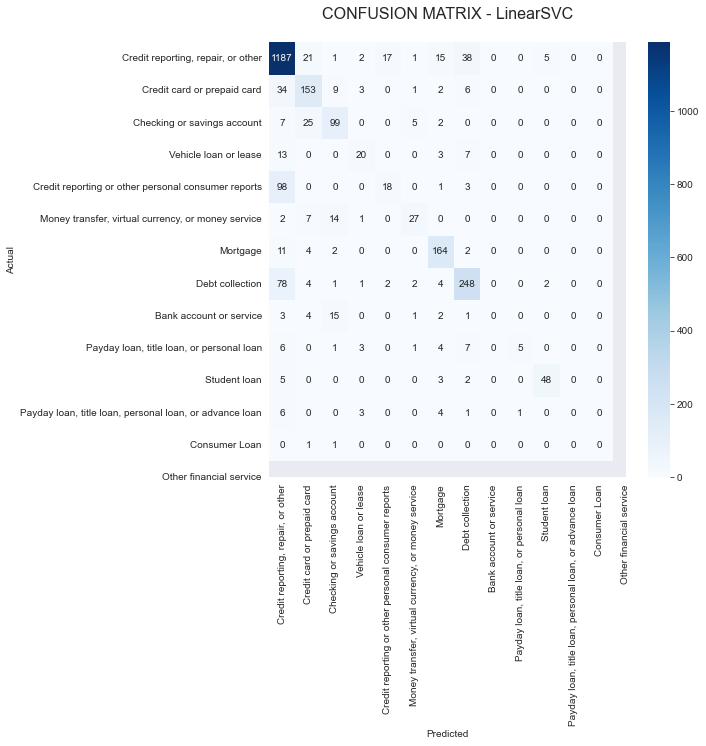

In [23]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16)

## the confusion matrix looks good (clear diagonal that represents correct classifications). But, there are cases were the complaint was classified in a wrong class. i.e, false positives

## finding misclassified complaints

In [27]:
for actual in category_id_df.category_id:
    for predicted in category_id_df.category_id:
        if actual != predicted and conf_mat.shape[0] > actual >= 0 and conf_mat.shape[1] > predicted >= 0 and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                                   id_to_category[predicted], 
                                                                   conf_mat[actual, predicted]))

            display(df2.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Product', 'Consumer_complaint']])
            print('')


'Credit reporting, repair, or other' predicted as 'Credit card or prepaid card' : 21 examples.


,Product,Consumer_complaint
1613589,"Credit reporting, repair, or other","Capital one well not respond to my mail, calls..."
948309,"Credit reporting, repair, or other",XXXX can not collect on a discharge debt. The ...
556948,"Credit reporting, repair, or other",I was alerted on XX/XX/XXXX of a hard credit i...
1593522,"Credit reporting, repair, or other","XXXXXXXX XXXX / 30 days late in XX/XX/XXXX, XX..."
4351525,"Credit reporting, repair, or other",ii just saw that someone tryed to open a card ...
2049064,"Credit reporting, repair, or other",I want this late payment deleted from my accou...
1741012,"Credit reporting, repair, or other",I was billed {$27.00} for no reason. I never a...
2674428,"Credit reporting, repair, or other","XXXX XXXX made me an offer for a credit card, ..."
2445991,"Credit reporting, repair, or other",Synchrony Bank issued me an XXXX store card in...
509960,"Credit reporting, repair, or other",I want this late payment deleted from my accou...



'Credit reporting, repair, or other' predicted as 'Debt collection' : 38 examples.


,Product,Consumer_complaint
1528462,"Credit reporting, repair, or other",I submitted a CFPB complaint on XX/XX/XXXX aga...
2205469,"Credit reporting, repair, or other",I am XXXX XXXX and Im submitting this complain...
2349797,"Credit reporting, repair, or other","XX/XX/2020 DEBT RECOVERY SOLUTIONS , LLC add a..."
1124154,"Credit reporting, repair, or other",I have requested proof of the original obligat...
2526912,"Credit reporting, repair, or other",This is a minor issue as this account is sched...
2453279,"Credit reporting, repair, or other",American Express is reporting a debt on my cre...
3597228,"Credit reporting, repair, or other",I filed a disputed that the credit report comp...
764538,"Credit reporting, repair, or other",National Credit Adjuster is reporting a debt o...
3058573,"Credit reporting, repair, or other",I currently have disputed an appt from XXXX XX...
2609680,"Credit reporting, repair, or other",This is a notice for FINANCIAL DATA SYSTEMS to...



'Credit card or prepaid card' predicted as 'Credit reporting, repair, or other' : 34 examples.


,Product,Consumer_complaint
2276180,Credit card or prepaid card,Wells Fargo is violating the privacy of indivi...
3737878,Credit card or prepaid card,IN REGARDS TO ; CAPITAL ONE XXXX XXXX XXXX XXX...
1176119,Credit card or prepaid card,Bank of America- XXXX XXXX XXXX for the amoun...
2149076,Credit card or prepaid card,On XX/XX/2018 I put a deposit on a XXXX XXXX X...
650394,Credit card or prepaid card,Navy Federal Credit Union continues to report ...
2522849,Credit card or prepaid card,on XX/XX/XXXX I got a credit alert stating wel...
3614351,Credit card or prepaid card,I am a victim of identity theft. We have been ...
1409869,Credit card or prepaid card,"XXXX XXXX Claim Date : XX/XX/XXXX, 2017 Claim ..."
3416035,Credit card or prepaid card,I have filed a dispute with XXXX XXXX. I now c...
3476812,Credit card or prepaid card,Problem with bank producing evidence of a cont...



'Checking or savings account' predicted as 'Credit card or prepaid card' : 25 examples.


,Product,Consumer_complaint
4352406,Checking or savings account,I am an XXXX. I won {$1000.00} from Bank of Am...
268690,Checking or savings account,On the night of XXXX XXXX XXXX I attempted to ...
2431814,Checking or savings account,"I use PayPal, I also have account with Synchro..."
2199704,Checking or savings account,My Debit card got blocked for suspicious trans...
1866188,Checking or savings account,I order merchandise from XXXX. After reviewing...
2231422,Checking or savings account,This complaint is about accrued interest that ...
1415487,Checking or savings account,On XX/XX/XXXX I logged into my SunTrust accoun...
1751267,Checking or savings account,Despite asking many times Upgrade Inc doesn't ...
1671417,Checking or savings account,I 've been having an ongoing dispute with a me...
1196923,Checking or savings account,I had initially purchased {$200.00} on coinbas...



'Credit reporting or other personal consumer reports' predicted as 'Credit reporting, repair, or other' : 98 examples.


,Product,Consumer_complaint
3808916,Credit reporting or other personal consumer re...,"When I reviewed my credit report, I discovered..."
4056310,Credit reporting or other personal consumer re...,I am listing accounts below that have been rep...
195689,Credit reporting or other personal consumer re...,I was a victim of Identity Theft several years...
3797288,Credit reporting or other personal consumer re...,I recently received a copy of my credit report...
1495662,Credit reporting or other personal consumer re...,After submitting 3 different disputes for the ...
...,...,...
259514,Credit reporting or other personal consumer re...,See document attached
350044,Credit reporting or other personal consumer re...,"Dear, XXXX XXXX XXXX XXXX XXXX XXXX XXXX, GA X..."
213731,Credit reporting or other personal consumer re...,"this was not sent in error, and not a material..."
481222,Credit reporting or other personal consumer re...,I discovered that some of the information on m...



'Debt collection' predicted as 'Credit reporting, repair, or other' : 78 examples.


,Product,Consumer_complaint
2001186,Debt collection,This company has reported a collection amount ...
512109,Debt collection,Midland Credit Managem {$1000.00} Under the Fa...
511207,Debt collection,"In regards to complaint number, XXXX, XXXX XXX..."
1091245,Debt collection,I am a victim of identity theft. I am writing ...
1655323,Debt collection,"1. 30/60 days past due, negative credit report..."
...,...,...
2753908,Debt collection,I XXXX XXXX am a victim of identity theft the ...
4489192,Debt collection,In the months of XXXX and XXXX of last year Iv...
3567913,Debt collection,In accordance with the Fair Credit Reporting a...
1387035,Debt collection,The three request ( dispute ) letters that hav...


## lets again find most co-related term with each category

In [29]:
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  *** Top unigrams: %s" %(', '.join(unigrams)))
  print("  *** Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  *** Top unigrams: bank, 2016, fee, suspect
  *** Top bigrams: bank charges, files xxxx, business bank, checking savings

==> 'Checking or savings account':
  *** Top unigrams: funds, chime, money, savings
  *** Top bigrams: information consent, savings account, claim denied, pay bills

==> 'Consumer Loan':
  *** Top unigrams: finance, references, ally, fin
  *** Top bigrams: ally financial, paying xxxx, settle xxxx, received loan

==> 'Credit card or prepaid card':
  *** Top unigrams: card, synchrony, amex, merchant
  *** Top bigrams: balance transfer, credit limit, american express, update account

==> 'Credit reporting or other personal consumer reports':
  *** Top unigrams: earnestly, document, material, hung
  *** Top bigrams: 1681 15, inquiries 15, belong want, rights list

==> 'Credit reporting, repair, or other':
  *** Top unigrams: equifax, experian, transunion, report
  *** Top bigrams: xxxx bank, refuses remove, xxxx xx, lived xxxx

==> 'Debt

## at last lets make predictions

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [36]:
sample_complaint='''They said they could n't change anything.'''

model.predict(fitted_vectorizer.transform([sample_complaint]))

array(['Credit reporting, repair, or other'], dtype=object)

## the model predicted the complaint as 'Credit reporting, repair, or other'    now lets verify whether its actually a student loan.

In [37]:
df2[df2['Consumer_complaint'] == sample_complaint]

,Product,Consumer_complaint,category_id
3451266,"Credit reporting, repair, or other",They said they could n't change anything.,0


## yes its correct our model predicted correctly       lets check for another example

In [41]:
#the above complaint i got it lucklily but for another lets keep a thgreshold to get all the complaints length in that range
threshold_length = 50
short_complaints = df2[df2["Consumer_complaint"].str.len() < threshold_length]
print(short_complaints[["Consumer_complaint"]])


                                        Consumer_complaint
3803850         I want all the hard inquries off my report
1323564   Unauthorized Credit Companies running my credit.
2190845     XXXX XXXX XXXX inquiry that was not authorized
2755323                        Inaccurate credit reporting
2335598                    I am a victim of identity theft
2555061                             Friday XX/XX/2020 2020
2393227                                Payment is too high
2337683                     Problem with credit reporting.
4021816                Information belongs to someone else
259514                               See document attached
3960394   There were fraudulent charges on my credit card.
1235867   inquires I do not recognize on my Equifax report
3568863                    I am a victim of idenity theft.
1590291                    I am a victim of identity theft
2555047          Tried to come to them with a half pay out
3477396    they charged me for something that I did n't 

In [48]:
sample_complaint2="The account is not mine."
model.predict(fitted_vectorizer.transform([sample_complaint]))

array(['Credit reporting, repair, or other'], dtype=object)

In [49]:
#lets check whether our predicted result is correct
df2[df2['Consumer_complaint'] == sample_complaint2]

,Product,Consumer_complaint,category_id
1112681,Debt collection,The account is not mine.,7


## as we can see the model mis classifies the complaint ... but still the model is doing its best as i have given it only 10000 values as data from 4 million records ..... but still its not enough..... there is always room for improvement